# E-Commerce Customer Churn Prediction - Model Training
## Training and Comparing Multiple ML Models



---
## Cell 1: Import Required Libraries
Import all necessary libraries for model training and evaluation.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Model persistence
import pickle
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ All libraries imported successfully!
XGBoost version: 3.1.2
LightGBM version: 4.6.0


---
## Cell 2: Load Preprocessed Data
Load the train and test datasets created during preprocessing.

In [ ]:
# Load preprocessed data
print("Loading preprocessed data...")
print("="*80)

X_train = pd.read_csv('/content/X_train.csv')
X_test = pd.read_csv('/content/X_test.csv')
y_train = pd.read_csv('/content/y_train.csv').values.ravel()
y_test = pd.read_csv('/content/y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures: {X_train.shape[1]}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

print("\nTarget Distribution in Training Set:")
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count:,} ({count/len(y_train)*100:.2f}%)")

print("\n✓ Data loaded successfully!")

Loading preprocessed data...
Training set: (40000, 38)
Test set: (10000, 38)

Features: 38
Training samples: 40,000
Test samples: 10,000

Target Distribution in Training Set:
  Class 0: 28,440 (71.10%)
  Class 1: 11,560 (28.90%)

✓ Data loaded successfully!


---
## Cell 3: Handle Class Imbalance with SMOTE
Apply SMOTE to balance the training data.

Handling Class Imbalance with SMOTE...
Before SMOTE:
  Class 0: 28,440
  Class 1: 11,560

✓ Missing values imputed.

After SMOTE:
  Class 0: 28,440
  Class 1: 28,440

Training set size increased from 40,000 to 56,880
✓ Class imbalance handled!


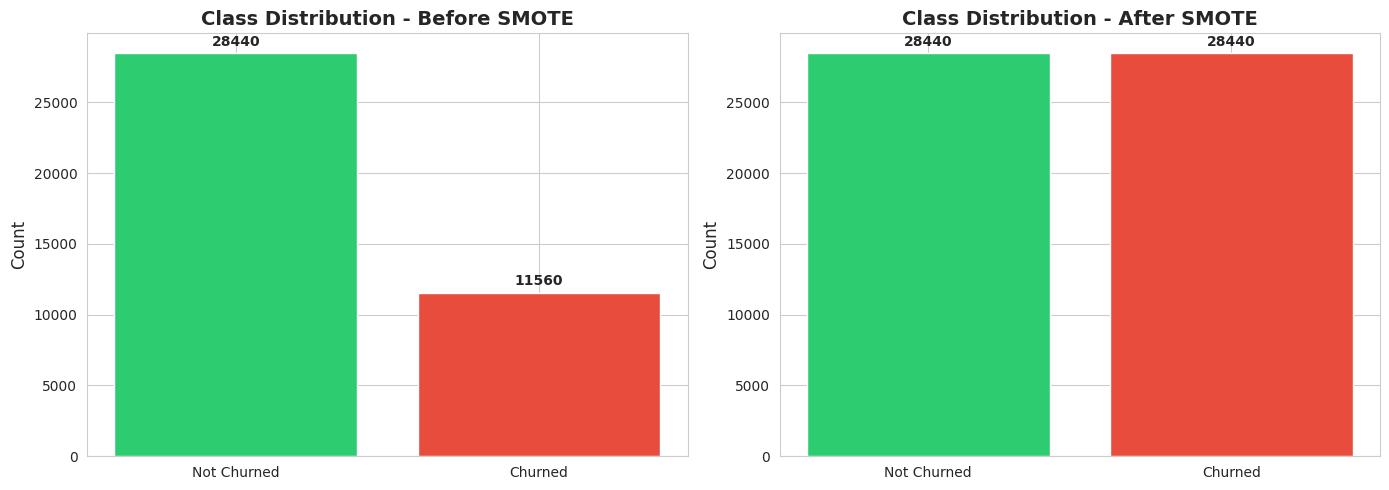

In [ ]:
print("Handling Class Imbalance with SMOTE...")
print("="*80)

print("Before SMOTE:")
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count:,}")

# Impute missing values before SMOTE
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame to maintain column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

print("\n✓ Missing values imputed.")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

print("\nAfter SMOTE:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count:,}")

print(f"\nTraining set size increased from {len(X_train):,} to {len(X_train_balanced):,}")
print("✓ Class imbalance handled!")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)
axes[0].bar(['Not Churned', 'Churned'], counts_before, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution - Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(counts_before):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# After SMOTE
unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
axes[1].bar(['Not Churned', 'Churned'], counts_after, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Class Distribution - After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
for i, v in enumerate(counts_after):
    axes[1].text(i, v + 500, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Cell 4: Define Model Evaluation Function
Create a comprehensive function to evaluate model performance.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Comprehensive model evaluation function
    """
    print(f"\n{'='*80}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*80}")

    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Prediction probabilities (for ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = model.decision_function(X_test)

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Training_Time': training_time,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1_Score': f1_score(y_test, y_test_pred),
        'ROC_AUC': roc_auc_score(y_test, y_test_proba)
    }

    # Print results
    print(f"\nTraining Time: {training_time:.2f} seconds")
    print(f"\nTraining Accuracy: {metrics['Train_Accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['Test_Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1_Score']:.4f}")
    print(f"ROC-AUC Score: {metrics['ROC_AUC']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Not Churned', 'Churned']))

    return metrics, model, y_test_pred, y_test_proba

print("✓ Evaluation function defined!")

✓ Evaluation function defined!


---
## Cell 5: Model 1 - Logistic Regression
Train a baseline Logistic Regression model.


Evaluating: Logistic Regression

Training Time: 0.78 seconds

Training Accuracy: 0.7436
Test Accuracy: 0.7329
Precision: 0.5267
Recall: 0.7464
F1 Score: 0.6176
ROC-AUC Score: 0.8071

Confusion Matrix:
[[5172 1938]
 [ 733 2157]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.88      0.73      0.79      7110
     Churned       0.53      0.75      0.62      2890

    accuracy                           0.73     10000
   macro avg       0.70      0.74      0.71     10000
weighted avg       0.77      0.73      0.74     10000



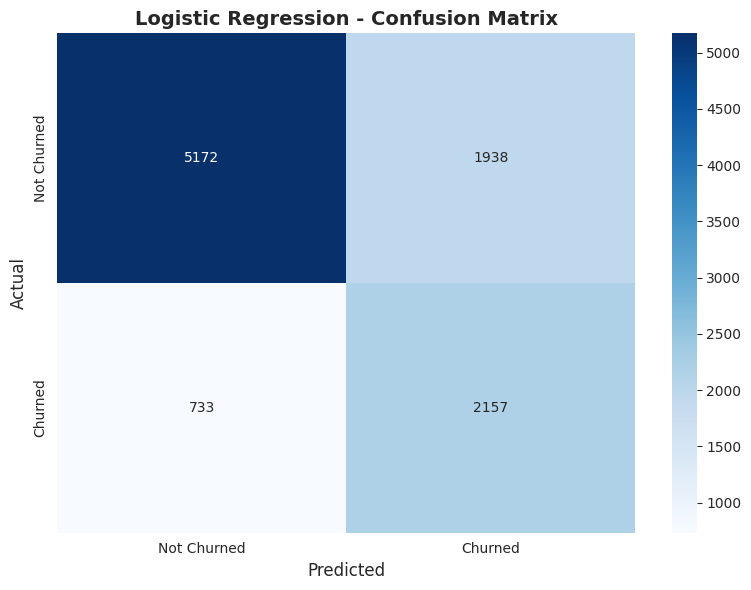


✓ Logistic Regression completed!


In [ ]:
# Initialize model
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

# Train and evaluate
lr_metrics, lr_trained, lr_pred, lr_proba = evaluate_model(
    lr_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "Logistic Regression"
)

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Logistic Regression completed!")

---
## Cell 6: Model 2 - Decision Tree
Train a Decision Tree classifier.


Evaluating: Decision Tree

Training Time: 1.47 seconds

Training Accuracy: 0.9080
Test Accuracy: 0.8837
Precision: 0.8044
Recall: 0.7896
F1 Score: 0.7969
ROC-AUC Score: 0.8993

Confusion Matrix:
[[6555  555]
 [ 608 2282]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.92      0.92      7110
     Churned       0.80      0.79      0.80      2890

    accuracy                           0.88     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.88      0.88      0.88     10000



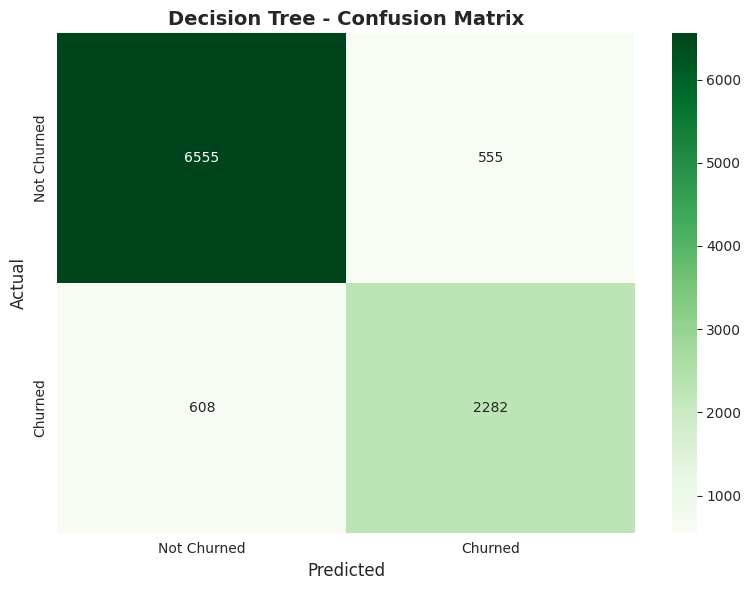


✓ Decision Tree completed!


In [ ]:
# Initialize model
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10
)

# Train and evaluate
dt_metrics, dt_trained, dt_pred, dt_proba = evaluate_model(
    dt_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "Decision Tree"
)

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Decision Tree - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Decision Tree completed!")

---
## Cell 7: Model 3 - Random Forest
Train a Random Forest ensemble model.


Evaluating: Random Forest

Training Time: 20.83 seconds

Training Accuracy: 0.9516
Test Accuracy: 0.9031
Precision: 0.8386
Recall: 0.8232
F1 Score: 0.8308
ROC-AUC Score: 0.9233

Confusion Matrix:
[[6652  458]
 [ 511 2379]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.94      0.93      7110
     Churned       0.84      0.82      0.83      2890

    accuracy                           0.90     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.90      0.90      0.90     10000



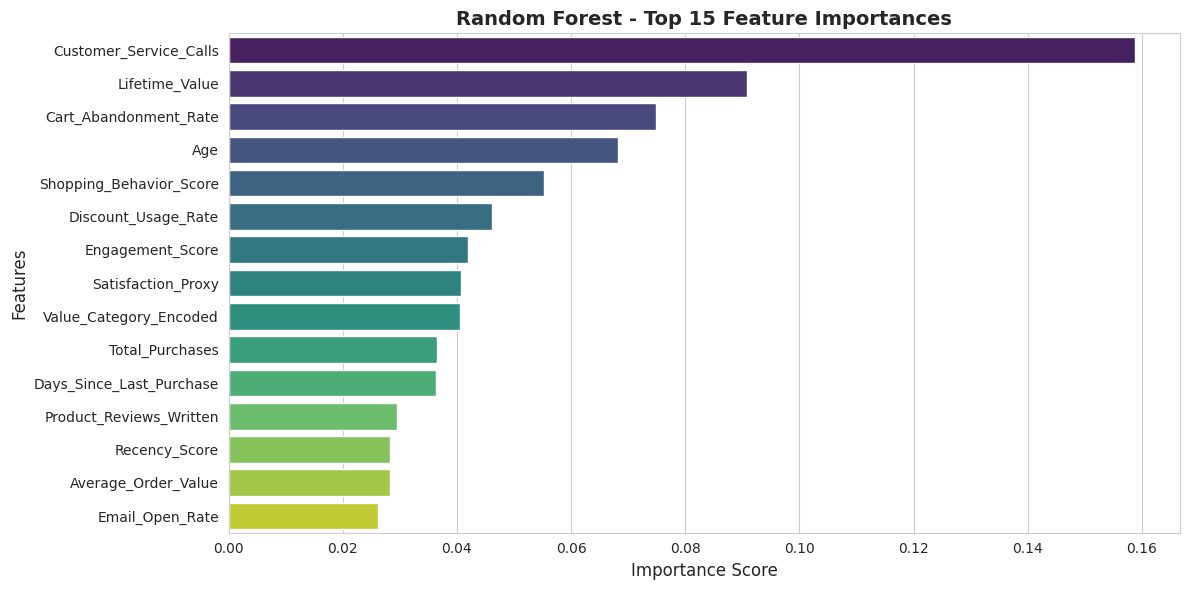

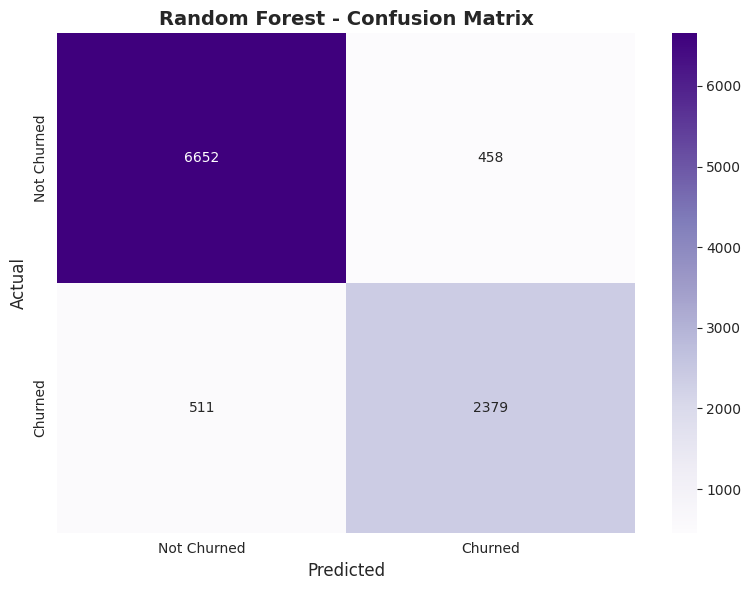


✓ Random Forest completed!


In [ ]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1
)

# Train and evaluate
rf_metrics, rf_trained, rf_pred, rf_proba = evaluate_model(
    rf_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "Random Forest"
)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_trained.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Random Forest completed!")

---
## Cell 8: Model 4 - XGBoost
Train an XGBoost gradient boosting model.


Evaluating: XGBoost

Training Time: 1.88 seconds

Training Accuracy: 0.9508
Test Accuracy: 0.9192
Precision: 0.9007
Recall: 0.8097
F1 Score: 0.8528
ROC-AUC Score: 0.9278

Confusion Matrix:
[[6852  258]
 [ 550 2340]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.96      0.94      7110
     Churned       0.90      0.81      0.85      2890

    accuracy                           0.92     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.92      0.92      0.92     10000



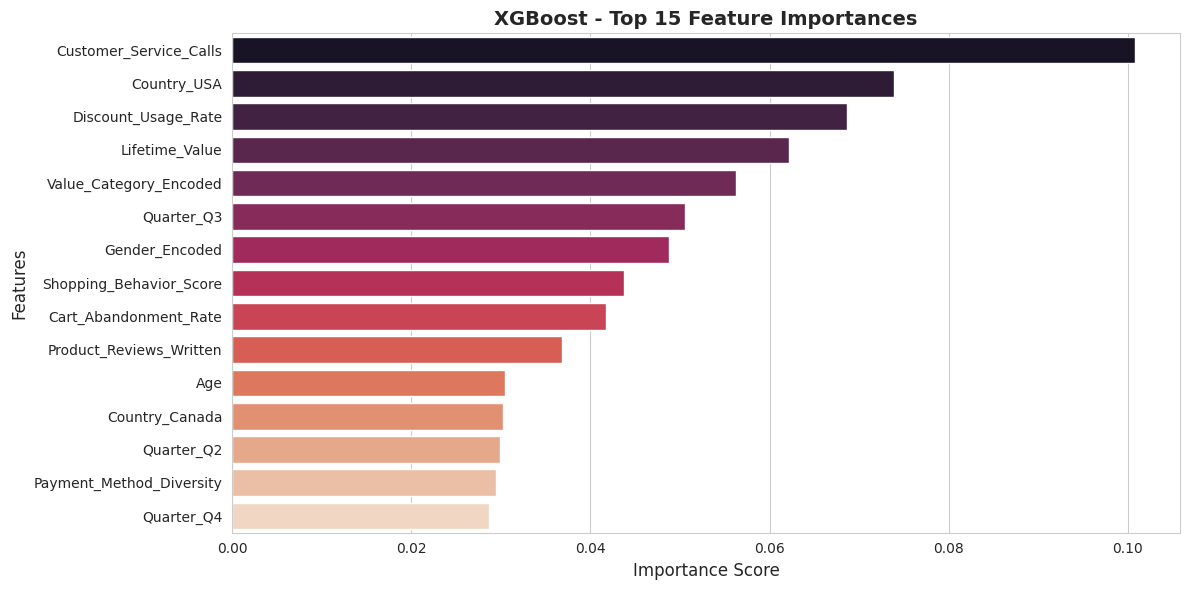

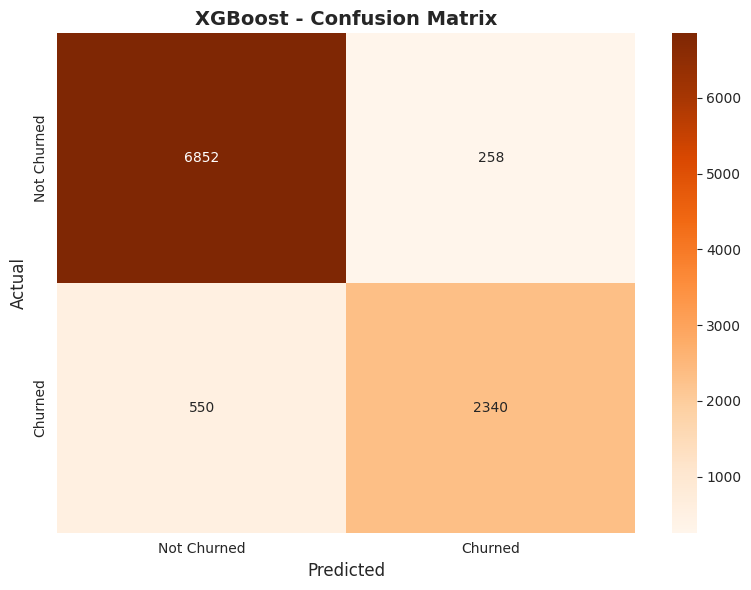


✓ XGBoost completed!


In [ ]:
# Initialize model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train and evaluate
xgb_metrics, xgb_trained, xgb_pred, xgb_proba = evaluate_model(
    xgb_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "XGBoost"
)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_trained.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='rocket')
plt.title('XGBoost - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ XGBoost completed!")

---
## Cell 9: Model 5 - LightGBM
Train a LightGBM gradient boosting model.


Evaluating: LightGBM

Training Time: 1.50 seconds

Training Accuracy: 0.9496
Test Accuracy: 0.9178
Precision: 0.9017
Recall: 0.8031
F1 Score: 0.8496
ROC-AUC Score: 0.9268

Confusion Matrix:
[[6857  253]
 [ 569 2321]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.96      0.94      7110
     Churned       0.90      0.80      0.85      2890

    accuracy                           0.92     10000
   macro avg       0.91      0.88      0.90     10000
weighted avg       0.92      0.92      0.92     10000



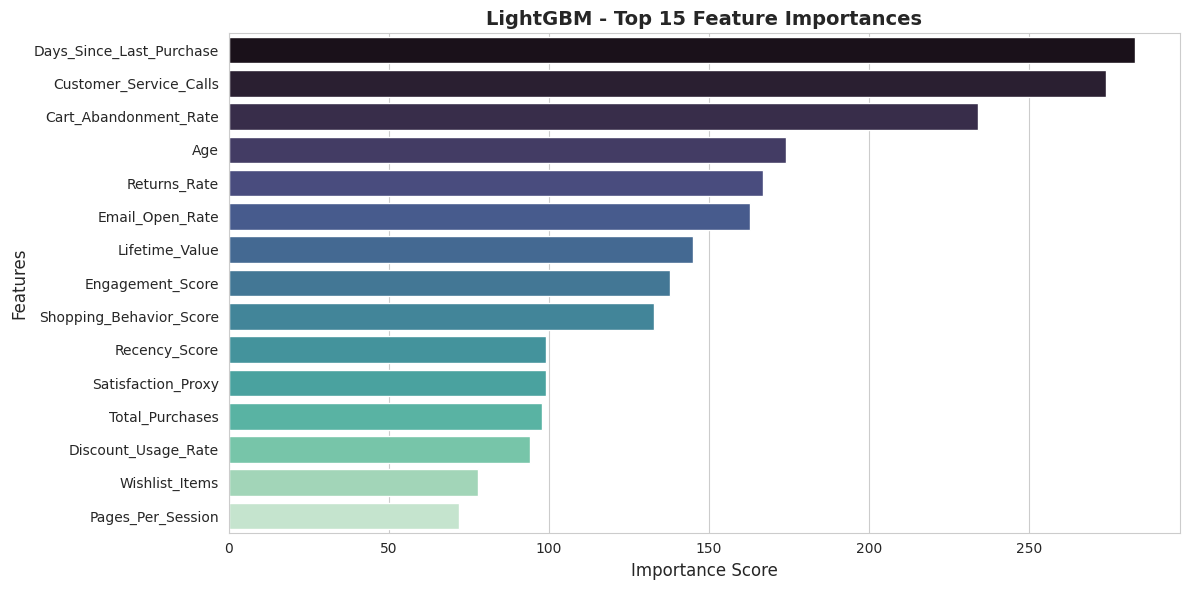

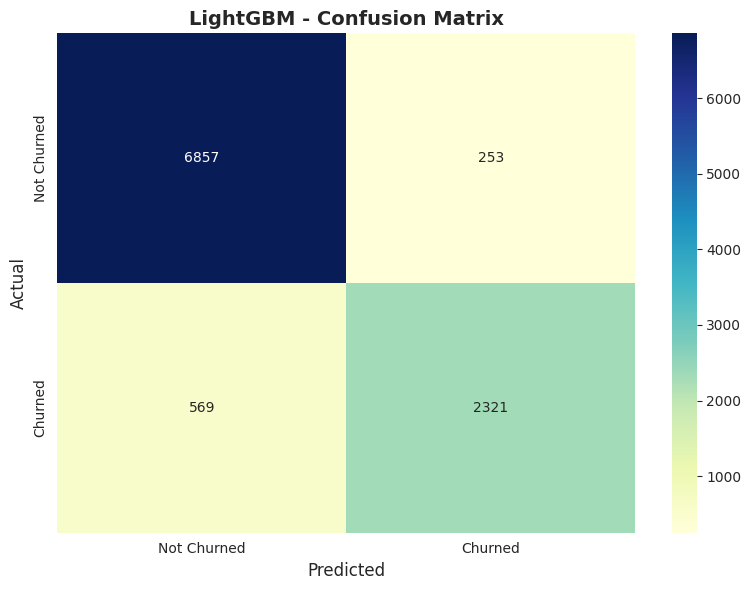


✓ LightGBM completed!


In [ ]:
# Initialize model
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    verbose=-1
)

# Train and evaluate
lgb_metrics, lgb_trained, lgb_pred, lgb_proba = evaluate_model(
    lgb_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "LightGBM"
)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_trained.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='mako')
plt.title('LightGBM - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, lgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('LightGBM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ LightGBM completed!")

---
## Cell 10: Model 6 - Gradient Boosting
Train a Scikit-learn Gradient Boosting model.


Evaluating: Gradient Boosting

Training Time: 79.32 seconds

Training Accuracy: 0.9459
Test Accuracy: 0.9185
Precision: 0.8949
Recall: 0.8135
F1 Score: 0.8523
ROC-AUC Score: 0.9265

Confusion Matrix:
[[6834  276]
 [ 539 2351]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.96      0.94      7110
     Churned       0.89      0.81      0.85      2890

    accuracy                           0.92     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.92      0.92      0.92     10000



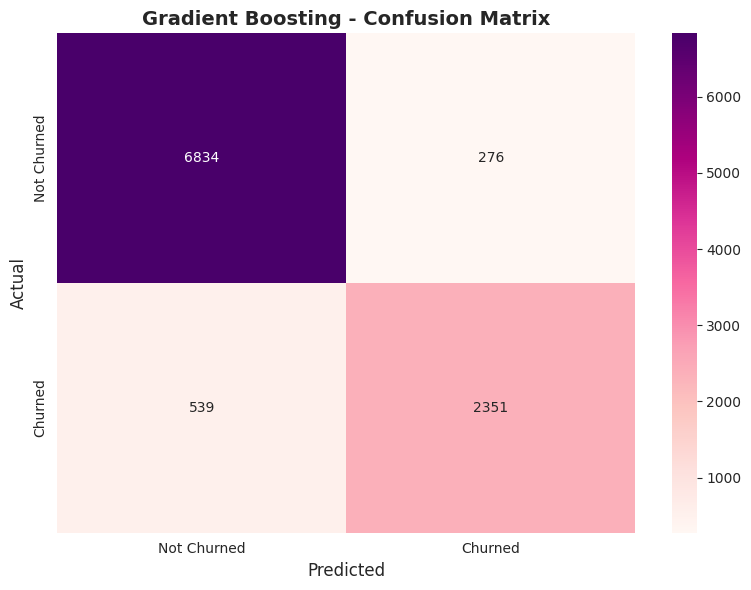


✓ Gradient Boosting completed!


In [ ]:
# Initialize model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8
)

# Train and evaluate
gb_metrics, gb_trained, gb_pred, gb_proba = evaluate_model(
    gb_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "Gradient Boosting"
)

# Confusion Matrix
cm = confusion_matrix(y_test, gb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Gradient Boosting - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Gradient Boosting completed!")

---
## Cell 11: Model 7 - Neural Network (MLP)
Train a Multi-Layer Perceptron neural network.


Evaluating: Neural Network (MLP)

Training Time: 16.46 seconds

Training Accuracy: 0.9056
Test Accuracy: 0.8843
Precision: 0.7950
Recall: 0.8080
F1 Score: 0.8014
ROC-AUC Score: 0.9118

Confusion Matrix:
[[6508  602]
 [ 555 2335]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.92      0.92      7110
     Churned       0.80      0.81      0.80      2890

    accuracy                           0.88     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.88      0.88      0.88     10000



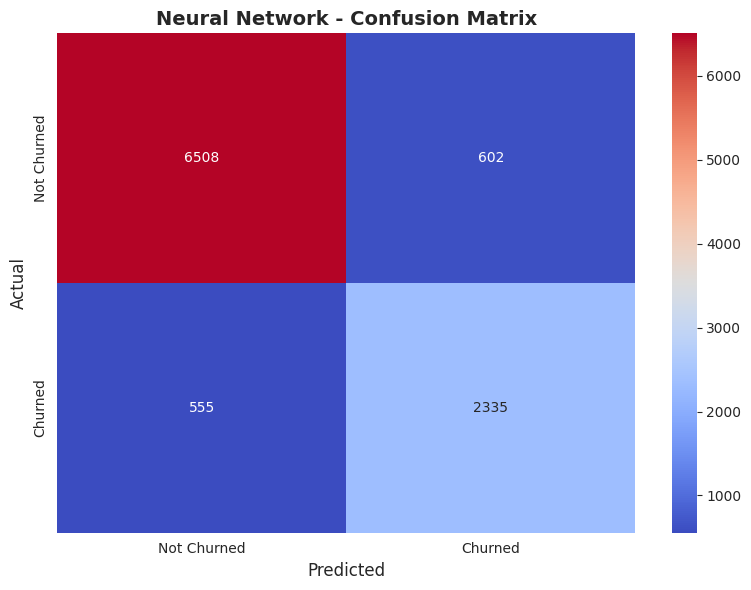


✓ Neural Network completed!


In [ ]:
# Initialize model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    random_state=42,
    max_iter=300,
    activation='relu',
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1
)

# Train and evaluate
mlp_metrics, mlp_trained, mlp_pred, mlp_proba = evaluate_model(
    mlp_model, X_train_balanced, y_train_balanced, X_test_imputed, y_test,
    "Neural Network (MLP)"
)

# Confusion Matrix
cm = confusion_matrix(y_test, mlp_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Neural Network completed!")

---
## Cell 12: Compare All Models
Create a comprehensive comparison of all trained models.

In [ ]:
# Compile all metrics
all_metrics = pd.DataFrame([
    lr_metrics,
    dt_metrics,
    rf_metrics,
    xgb_metrics,
    lgb_metrics,
    gb_metrics,
    mlp_metrics
])

# Sort by F1 Score (balanced metric for imbalanced data)
all_metrics_sorted = all_metrics.sort_values('F1_Score', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("MODEL COMPARISON - ALL METRICS")
print("="*100)
print(all_metrics_sorted.to_string(index=False))

# Highlight best model
best_model = all_metrics_sorted.iloc[0]
print("\n" + "="*100)
print(f"🏆 BEST MODEL: {best_model['Model']}")
print("="*100)
print(f"Test Accuracy: {best_model['Test_Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1 Score: {best_model['F1_Score']:.4f}")
print(f"ROC-AUC: {best_model['ROC_AUC']:.4f}")
print(f"Training Time: {best_model['Training_Time']:.2f} seconds")

# Save comparison
all_metrics_sorted.to_csv('model_comparison.csv', index=False)
print("\n✓ Model comparison saved to 'model_comparison.csv'")


MODEL COMPARISON - ALL METRICS
               Model  Training_Time  Train_Accuracy  Test_Accuracy  Precision  Recall  F1_Score  ROC_AUC
             XGBoost         1.8835          0.9508         0.9192     0.9007  0.8097    0.8528   0.9278
   Gradient Boosting        79.3182          0.9459         0.9185     0.8949  0.8135    0.8523   0.9265
            LightGBM         1.4964          0.9496         0.9178     0.9017  0.8031    0.8496   0.9268
       Random Forest        20.8311          0.9516         0.9031     0.8386  0.8232    0.8308   0.9233
Neural Network (MLP)        16.4563          0.9056         0.8843     0.7950  0.8080    0.8014   0.9118
       Decision Tree         1.4670          0.9080         0.8837     0.8044  0.7896    0.7969   0.8993
 Logistic Regression         0.7843          0.7436         0.7329     0.5267  0.7464    0.6176   0.8071

🏆 BEST MODEL: XGBoost
Test Accuracy: 0.9192
Precision: 0.9007
Recall: 0.8097
F1 Score: 0.8528
ROC-AUC: 0.9278
Training Time: 1.

---
## Cell 13: Visualize Model Comparison
Create visual comparisons of model performance.

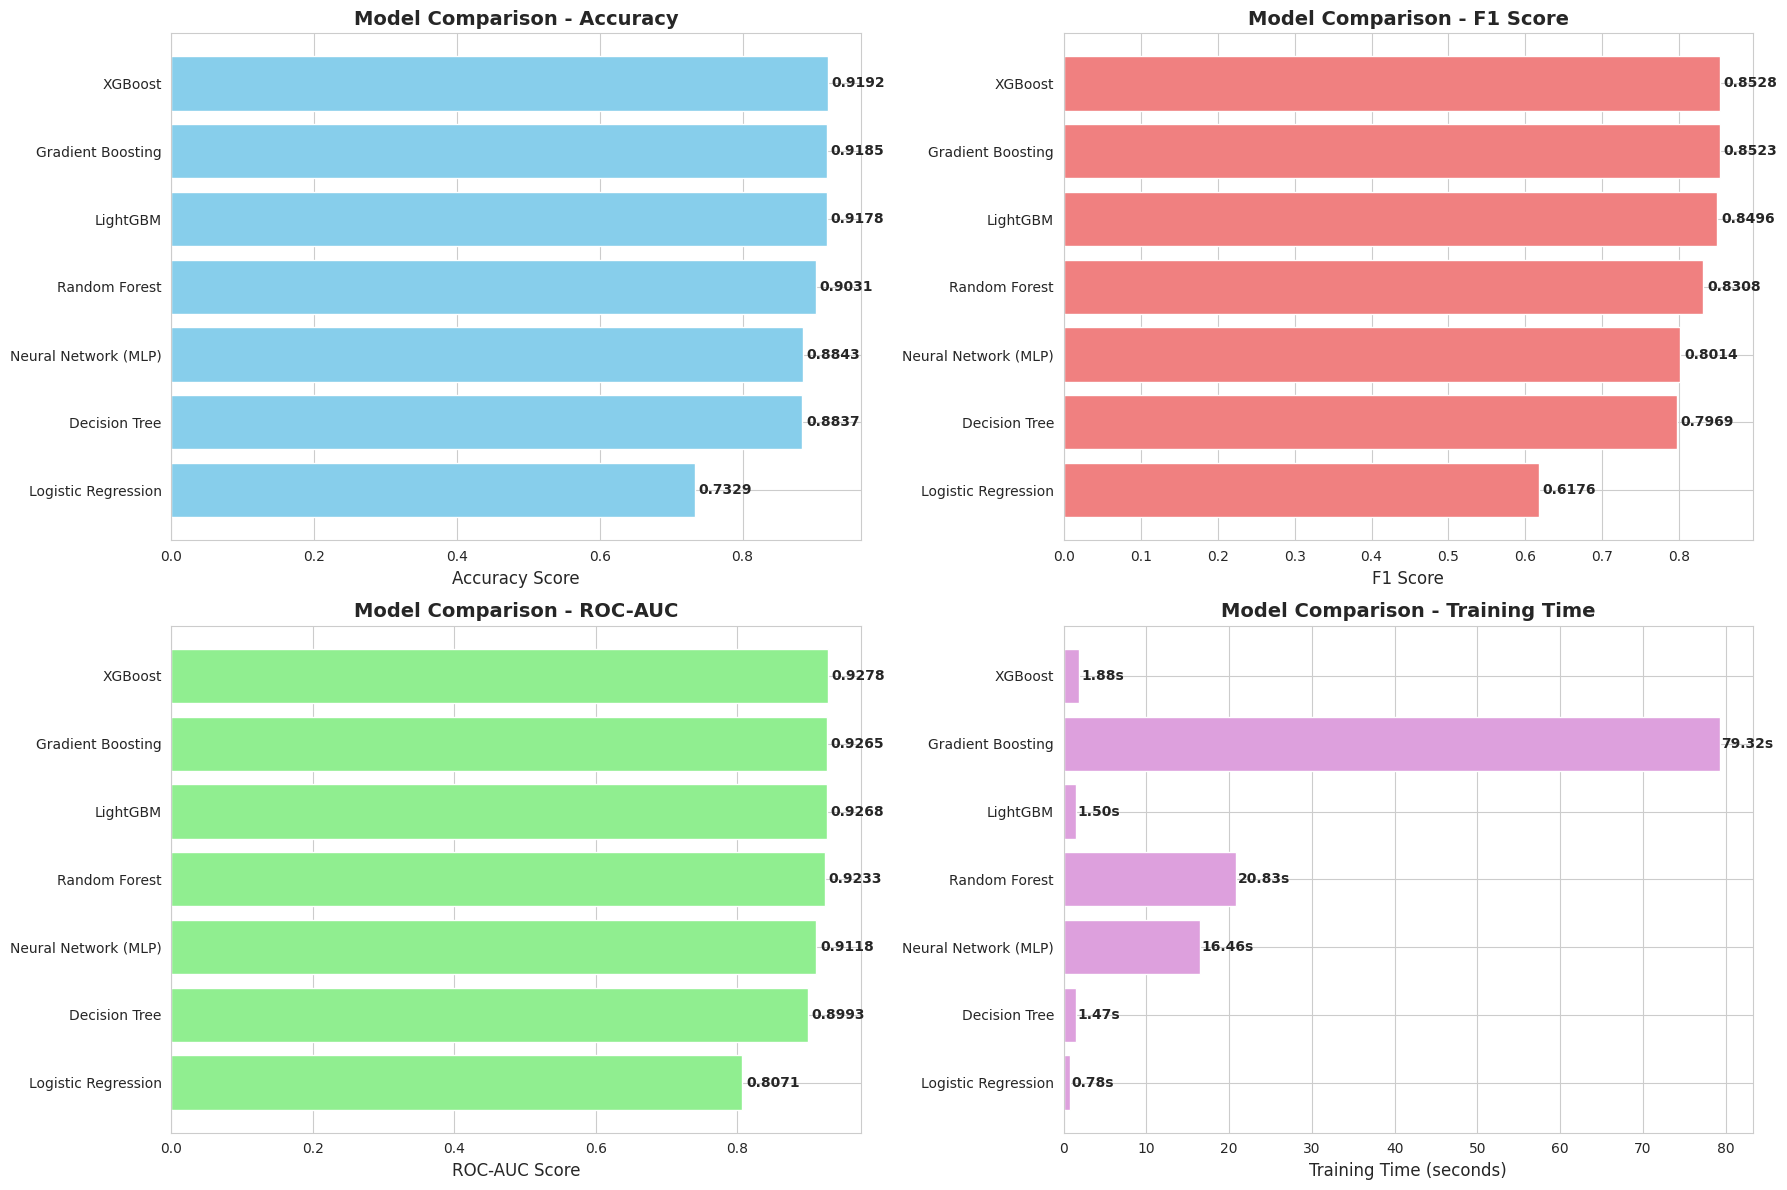

✓ Model comparison visualizations complete!


In [ ]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Accuracy Comparison
x_pos = np.arange(len(all_metrics_sorted))
axes[0, 0].barh(x_pos, all_metrics_sorted['Test_Accuracy'], color='skyblue')
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(all_metrics_sorted['Model'])
axes[0, 0].set_xlabel('Accuracy Score', fontsize=12)
axes[0, 0].set_title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
for i, v in enumerate(all_metrics_sorted['Test_Accuracy']):
    axes[0, 0].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# 2. F1 Score Comparison
axes[0, 1].barh(x_pos, all_metrics_sorted['F1_Score'], color='lightcoral')
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(all_metrics_sorted['Model'])
axes[0, 1].set_xlabel('F1 Score', fontsize=12)
axes[0, 1].set_title('Model Comparison - F1 Score', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
for i, v in enumerate(all_metrics_sorted['F1_Score']):
    axes[0, 1].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# 3. ROC-AUC Comparison
axes[1, 0].barh(x_pos, all_metrics_sorted['ROC_AUC'], color='lightgreen')
axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(all_metrics_sorted['Model'])
axes[1, 0].set_xlabel('ROC-AUC Score', fontsize=12)
axes[1, 0].set_title('Model Comparison - ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
for i, v in enumerate(all_metrics_sorted['ROC_AUC']):
    axes[1, 0].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# 4. Training Time Comparison
axes[1, 1].barh(x_pos, all_metrics_sorted['Training_Time'], color='plum')
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(all_metrics_sorted['Model'])
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1, 1].set_title('Model Comparison - Training Time', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
for i, v in enumerate(all_metrics_sorted['Training_Time']):
    axes[1, 1].text(v + 0.2, i, f'{v:.2f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Model comparison visualizations complete!")

---
## Cell 14: Multi-Metric Comparison
Visualize Precision, Recall, and F1 Score together.

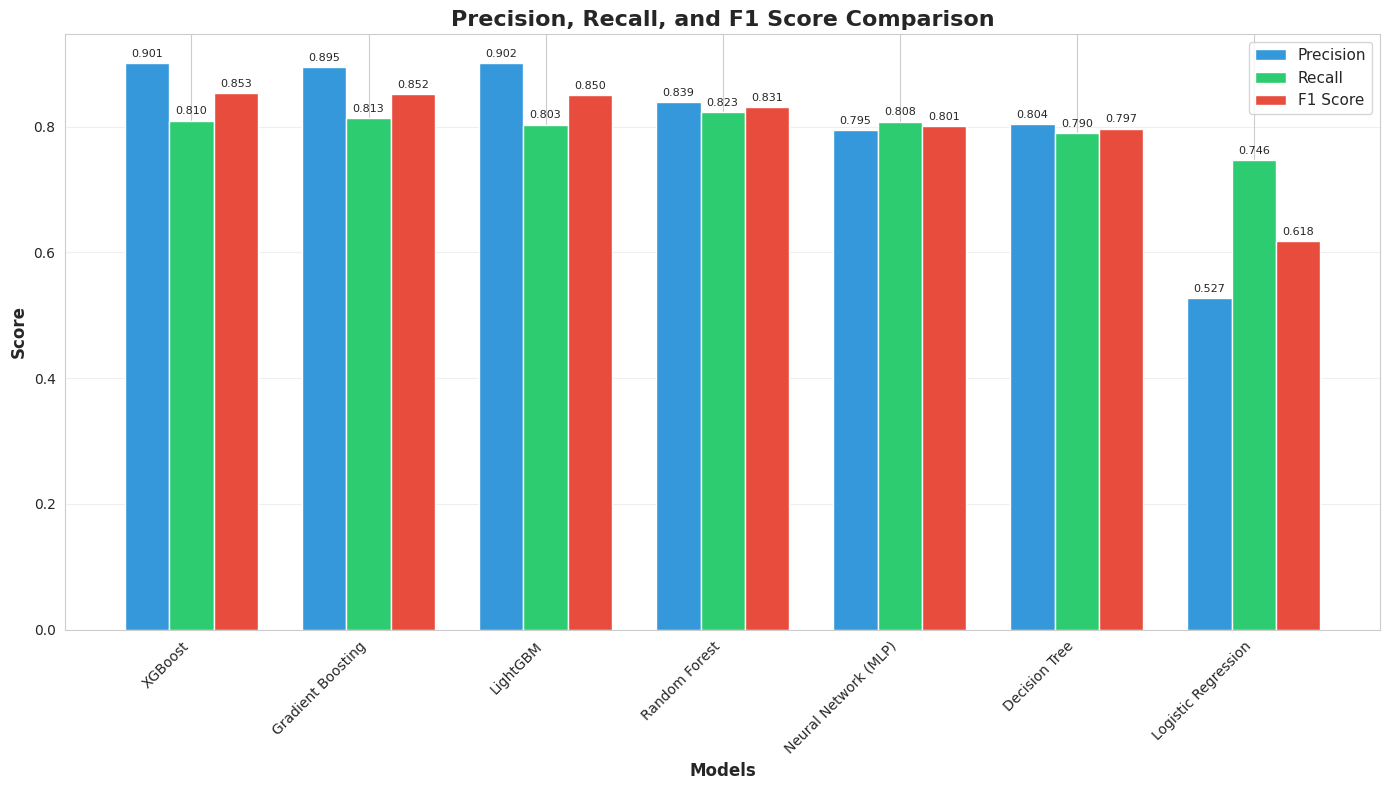

✓ Multi-metric comparison complete!


In [ ]:
# Multi-metric comparison
metrics_to_plot = ['Precision', 'Recall', 'F1_Score']
x = np.arange(len(all_metrics_sorted))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - width, all_metrics_sorted['Precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x, all_metrics_sorted['Recall'], width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, all_metrics_sorted['F1_Score'], width, label='F1 Score', color='#e74c3c')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Precision, Recall, and F1 Score Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_metrics_sorted['Model'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

print("✓ Multi-metric comparison complete!")

---
## Cell 15: ROC Curve Comparison
Plot ROC curves for all models on the same graph.

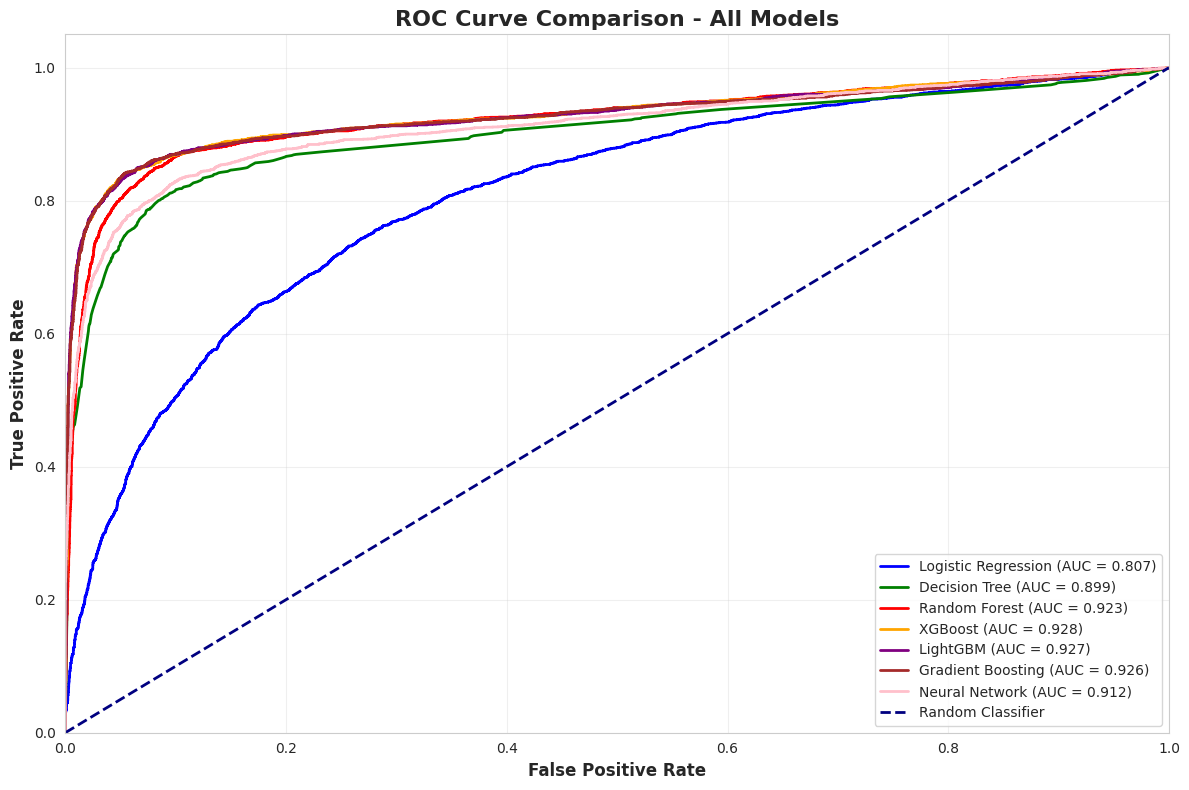

✓ ROC curve comparison complete!


In [ ]:
# Store all predictions and probabilities
models_data = [
    ('Logistic Regression', lr_proba),
    ('Decision Tree', dt_proba),
    ('Random Forest', rf_proba),
    ('XGBoost', xgb_proba),
    ('LightGBM', lgb_proba),
    ('Gradient Boosting', gb_proba),
    ('Neural Network', mlp_proba)
]

# Plot ROC curves
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

for idx, (model_name, y_proba) in enumerate(models_data):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curve comparison complete!")

---
## Cell 16: Hyperparameter Tuning for Best Model
Perform grid search to optimize the best performing model.

In [ ]:
print("Hyperparameter Tuning for Best Model...")
print("="*80)

# Identify best model (based on F1 score)
best_model_name = all_metrics_sorted.iloc[0]['Model']
print(f"Best Model: {best_model_name}")
print(f"Current F1 Score: {all_metrics_sorted.iloc[0]['F1_Score']:.4f}\n")

# Define parameter grids for different models
if 'XGBoost' in best_model_name:
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
elif 'LightGBM' in best_model_name:
    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
elif 'Random Forest' in best_model_name:
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 5, 10]
    }
elif 'Gradient Boosting' in best_model_name:
    model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
else:
    # Default to XGBoost if model not recognized
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.1, 0.2]
    }

print("Starting Grid Search...")
print(f"Parameter grid: {param_grid}\n")

# Perform grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Use a smaller sample for faster tuning (optional)
sample_size = min(20000, len(X_train_balanced))
X_sample = X_train_balanced[:sample_size]
y_sample = y_train_balanced[:sample_size]

grid_search.fit(X_sample, y_sample)

print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

# Train best model on full data
best_tuned_model = grid_search.best_estimator_
best_tuned_model.fit(X_train_balanced, y_train_balanced)

print("\n✓ Hyperparameter tuning complete!")

Hyperparameter Tuning for Best Model...
Best Model: XGBoost
Current F1 Score: 0.8528

Starting Grid Search...
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [5, 7, 9], 'learning_rate': [0.05, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}

Fitting 3 folds for each of 72 candidates, totalling 216 fits

GRID SEARCH RESULTS
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation F1 Score: 0.8454

✓ Hyperparameter tuning complete!


---
## Cell 17: Evaluate Tuned Model
Evaluate the performance of the optimized model.

Evaluating Tuned Model...

TUNED MODEL PERFORMANCE
Accuracy: 0.9196
Precision: 0.9021
Recall: 0.8097
F1_Score: 0.8534
ROC_AUC: 0.9282

Confusion Matrix:
[[6856  254]
 [ 550 2340]]

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.96      0.94      7110
     Churned       0.90      0.81      0.85      2890

    accuracy                           0.92     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.92      0.92      0.92     10000



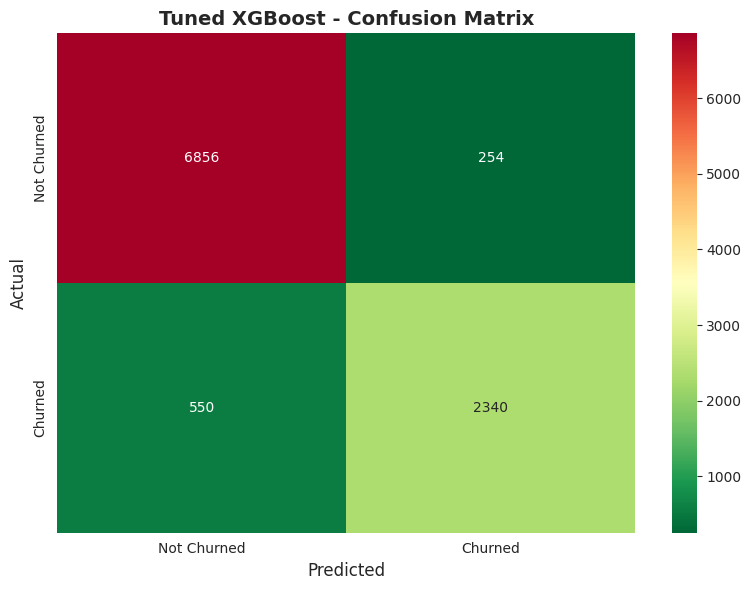


BEFORE vs AFTER TUNING
   Metric  Before  After  Improvement
 Accuracy  0.9192 0.9196       0.0004
Precision  0.9007 0.9021       0.0014
   Recall  0.8097 0.8097       0.0000
 F1_Score  0.8528 0.8534       0.0006
  ROC_AUC  0.9278 0.9282       0.0004

✓ Tuned model evaluation complete!


In [24]:
print("Evaluating Tuned Model...")
print("="*80)

# Predictions
y_test_pred_tuned = best_tuned_model.predict(X_test_imputed)
y_test_proba_tuned = best_tuned_model.predict_proba(X_test_imputed)[:, 1]

# Calculate metrics
tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred_tuned),
    'Precision': precision_score(y_test, y_test_pred_tuned),
    'Recall': recall_score(y_test, y_test_pred_tuned),
    'F1_Score': f1_score(y_test, y_test_pred_tuned),
    'ROC_AUC': roc_auc_score(y_test, y_test_proba_tuned)
}

print("\nTUNED MODEL PERFORMANCE")
print("="*80)
for metric, value in tuned_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)
print(f"\nConfusion Matrix:")
print(cm_tuned)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_tuned, target_names=['Not Churned', 'Churned']))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='RdYlGn_r',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title(f'Tuned {best_model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Compare before and after tuning
print("\n" + "="*80)
print("BEFORE vs AFTER TUNING")
print("="*80)
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC'],
    'Before': [
        all_metrics_sorted.iloc[0]['Test_Accuracy'],
        all_metrics_sorted.iloc[0]['Precision'],
        all_metrics_sorted.iloc[0]['Recall'],
        all_metrics_sorted.iloc[0]['F1_Score'],
        all_metrics_sorted.iloc[0]['ROC_AUC']
    ],
    'After': list(tuned_metrics.values())
})
comparison['Improvement'] = comparison['After'] - comparison['Before']
print(comparison.to_string(index=False))

print("\n✓ Tuned model evaluation complete!")

---
## Cell 18: Feature Importance from Best Model
Analyze which features are most important for predictions.


TOP 20 MOST IMPORTANT FEATURES
                 Feature  Importance
  Customer_Service_Calls      0.1364
 Shopping_Behavior_Score      0.0736
          Lifetime_Value      0.0726
             Country_USA      0.0601
              Quarter_Q3      0.0554
     Discount_Usage_Rate      0.0548
          Gender_Encoded      0.0529
 Product_Reviews_Written      0.0376
              Quarter_Q2      0.0345
                     Age      0.0332
   Cart_Abandonment_Rate      0.0315
         Country_Germany      0.0307
          Country_France      0.0273
          Country_Canada      0.0264
Payment_Method_Diversity      0.0249
              Quarter_Q4      0.0247
Days_Since_Last_Purchase      0.0221
              Country_UK      0.0215
        Engagement_Score      0.0205
         Total_Purchases      0.0185


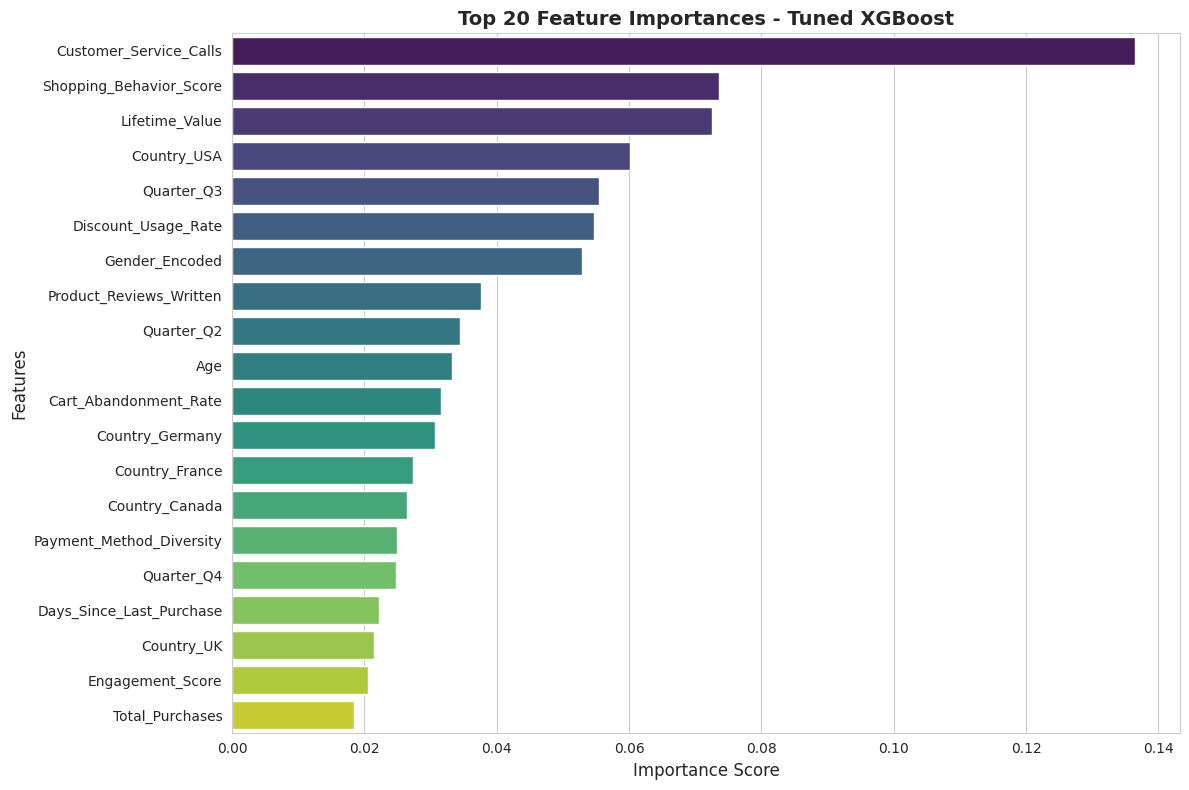


✓ Feature importance saved to 'feature_importance.csv'

✓ Feature importance analysis complete!


In [25]:
# Get feature importance from tuned model
if hasattr(best_tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_tuned_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTOP 20 MOST IMPORTANT FEATURES")
    print("="*80)
    print(feature_importance.head(20).to_string(index=False))

    # Visualize top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    sns.barplot(data=top_20, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 20 Feature Importances - Tuned {best_model_name}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("\n✓ Feature importance saved to 'feature_importance.csv'")
else:
    print("Feature importance not available for this model.")

print("\n✓ Feature importance analysis complete!")

---
## Cell 19: Save Best Model
Save the trained model for future use.

In [26]:
print("Saving Best Model...")
print("="*80)

# Save using joblib (recommended for scikit-learn models)
model_filename = f'best_churn_model_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_tuned_model, model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save using pickle as backup
pickle_filename = f'best_churn_model_{best_model_name.replace(" ", "_").lower()}.pickle'
with open(pickle_filename, 'wb') as f:
    pickle.dump(best_tuned_model, f)
print(f"✓ Model also saved as: {pickle_filename}")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'best_parameters': grid_search.best_params_,
    'metrics': tuned_metrics,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': X_train.shape[1],
    'feature_names': X_train.columns.tolist()
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
print("✓ Model metadata saved as: model_metadata.json")

print("\n" + "="*80)
print("MODEL SAVED SUCCESSFULLY!")
print("="*80)
print(f"Model: {best_model_name}")
print(f"F1 Score: {tuned_metrics['F1_Score']:.4f}")
print(f"ROC-AUC: {tuned_metrics['ROC_AUC']:.4f}")
print(f"Accuracy: {tuned_metrics['Accuracy']:.4f}")

Saving Best Model...
✓ Model saved as: best_churn_model_xgboost.pkl
✓ Model also saved as: best_churn_model_xgboost.pickle
✓ Model metadata saved as: model_metadata.json

MODEL SAVED SUCCESSFULLY!
Model: XGBoost
F1 Score: 0.8534
ROC-AUC: 0.9282
Accuracy: 0.9196


---
## Cell 20: Load and Test Saved Model
Demonstrate how to load and use the saved model.

In [27]:
print("Testing Model Loading...")
print("="*80)

# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"✓ Model loaded from: {model_filename}")

# Test prediction on a few samples
sample_data = X_test_imputed.head(5)
predictions = loaded_model.predict(sample_data)
probabilities = loaded_model.predict_proba(sample_data)[:, 1]

print("\nSample Predictions:")
print("="*80)
results = pd.DataFrame({
    'Actual': y_test[:5],
    'Predicted': predictions,
    'Churn_Probability': probabilities
})
results['Prediction_Status'] = results.apply(
    lambda x: 'Correct' if x['Actual'] == x['Predicted'] else 'Incorrect', axis=1
)
print(results.to_string(index=False))

# Verify model performance
all_predictions = loaded_model.predict(X_test_imputed)
test_accuracy = accuracy_score(y_test, all_predictions)
print(f"\n✓ Model verification complete!")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nModel is ready for deployment!")

Testing Model Loading...
✓ Model loaded from: best_churn_model_xgboost.pkl

Sample Predictions:
 Actual  Predicted  Churn_Probability Prediction_Status
      0          0             0.0633           Correct
      0          0             0.0856           Correct
      0          0             0.0795           Correct
      0          0             0.0514           Correct
      0          0             0.0477           Correct

✓ Model verification complete!
Test Accuracy: 0.9196

Model is ready for deployment!


---
## Cell 21: Model Training Summary
Comprehensive summary of the entire training process.

In [28]:
print("="*100)
print("MODEL TRAINING SUMMARY")
print("="*100)

summary = f"""
✓ TRAINING COMPLETED SUCCESSFULLY!

📊 DATASET:
   - Training samples: {len(X_train_balanced):,} (after SMOTE)
   - Test samples: {len(X_test):,}
   - Features: {X_train.shape[1]}

🤖 MODELS TRAINED: 7
   1. Logistic Regression
   2. Decision Tree
   3. Random Forest
   4. XGBoost
   5. LightGBM
   6. Gradient Boosting
   7. Neural Network (MLP)

🏆 BEST MODEL: {best_model_name}
   - Test Accuracy: {tuned_metrics['Accuracy']:.4f}
   - Precision: {tuned_metrics['Precision']:.4f}
   - Recall: {tuned_metrics['Recall']:.4f}
   - F1 Score: {tuned_metrics['F1_Score']:.4f}
   - ROC-AUC: {tuned_metrics['ROC_AUC']:.4f}

⚙️ OPTIMIZATION:
   - Method: Grid Search with 3-fold Cross-Validation
   - Scoring Metric: F1 Score
   - Best Parameters: {grid_search.best_params_}

💾 SAVED FILES:
   - Model: {model_filename}
   - Metadata: model_metadata.json
   - Comparison: model_comparison.csv
   - Feature Importance: feature_importance.csv

🎯 KEY INSIGHTS:
   - SMOTE was used to handle class imbalance
   - {best_model_name} outperformed other models
   - Model is ready for deployment and predictions
   - Feature importance analysis reveals key churn drivers

📈 NEXT STEPS:
   1. Deploy model to production
   2. Create prediction API/interface
   3. Monitor model performance over time
   4. Implement A/B testing for business impact
   5. Regular retraining with new data

"""

print(summary)
print("="*100)
print("✓ MODEL TRAINING PHASE COMPLETE!")
print("="*100)

MODEL TRAINING SUMMARY

✓ TRAINING COMPLETED SUCCESSFULLY!

📊 DATASET:
   - Training samples: 56,880 (after SMOTE)
   - Test samples: 10,000
   - Features: 38

🤖 MODELS TRAINED: 7
   1. Logistic Regression
   2. Decision Tree
   3. Random Forest
   4. XGBoost
   5. LightGBM
   6. Gradient Boosting
   7. Neural Network (MLP)

🏆 BEST MODEL: XGBoost
   - Test Accuracy: 0.9196
   - Precision: 0.9021
   - Recall: 0.8097
   - F1 Score: 0.8534
   - ROC-AUC: 0.9282

⚙️ OPTIMIZATION:
   - Method: Grid Search with 3-fold Cross-Validation
   - Scoring Metric: F1 Score
   - Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

💾 SAVED FILES:
   - Model: best_churn_model_xgboost.pkl
   - Metadata: model_metadata.json
   - Comparison: model_comparison.csv
   - Feature Importance: feature_importance.csv

🎯 KEY INSIGHTS:
   - SMOTE was used to handle class imbalance
   - XGBoost outperformed other models
   - Model is ready for deploy